In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize_scalar
from sklearn import linear_model
from sklearn.metrics.pairwise import euclidean_distances

In [318]:
### ANNOTATIONS
METADATA_SID = "data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID = "data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid = pd.read_table(METADATA_SID, sep = "\t")
metadata_pid = pd.read_table(METADATA_PID, sep = "\t")

### DATA
# Removed outliers, patients with timepoints from different batches and batch 5
FLTR_YEOH = "tmp/fltr_yeoh.tsv"
fltr_yeoh = pd.read_table(FLTR_YEOH, sep = "\t")
CORRECTED_YEOH = "tmp/corrected_yeoh.tsv"
corrected_yeoh = pd.read_table(CORRECTED_YEOH, sep = "\t")

metadata = metadata_sid.loc[list(fltr_yeoh)]

In [319]:
## Simulated D8
# Chose pi that minimises the euclidean distance between D8 and D8s
pi = 0.6
N = N01

D8s = pi * D0 + (1 - pi) * N
# Optimising for smallest L2norm between D8 and D8s
loss_fn = lambda pi: np.linalg.norm(D8 - (pi * D0 + (1 - pi) * N))
pi_hat = minimize_scalar(loss_fn, method='brent')
print(pi_hat)

     fun: 62740.75127022642
    nfev: 14
     nit: 10
 success: True
       x: 0.5426422012552434


#### Batch effects

In [320]:
print(metadata.tail(3))
metadata_sid.loc[sid_d0]

     batch_info class_info subtype  label
N01           2          N  Normal      0
N02           2          N  Normal      0
N04           2          N  Normal      0


batch_info     10
class_info     D0
subtype       MLL
label           0
Name: P211_D0, dtype: object

## Assess viability
- Analysing the coefficients

In [362]:
subtype = "TEL-AML1"
X_subtype = corrected_yeoh.loc[:, metadata.subtype == subtype]
sid_subtype = list(X_subtype)
pid_subtype = [sid[0:4] for sid in sid_subtype]
pid_subtype = list(dict.fromkeys(pid_subtype))

N01 = corrected_yeoh["N01"]
N02 = corrected_yeoh["N02"]
N04 = corrected_yeoh["N04"]

[0.64897938]
[0.53478326]
[0.64548476]


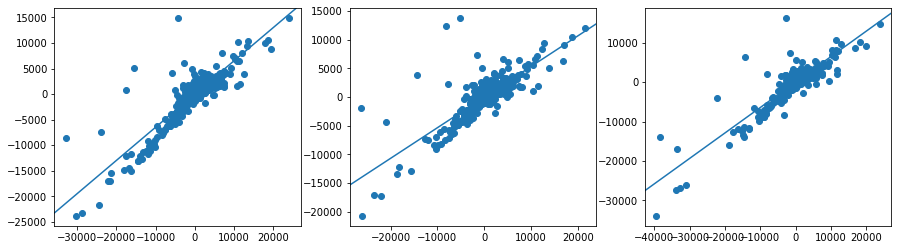

In [363]:
# coefficients = {}
# for pid in pid_subtype:
# #     print(pid)
# #     print(metadata_pid.loc[pid, ["label", "treatment_type"]])
pid = "P013"
sid_d0 = pid + "_D0"
sid_d8 = pid + "_D8"
#     print(metadata_sid.loc[sid_d0, "batch_info"])
D0 = X_subtype[sid_d0]
D8 = X_subtype[sid_d8]

fig, axarr = plt.subplots(1, 3, figsize=(15, 4))
pi = []
for N, ax in zip([N01, N02, N04], axarr):
    delta2 = D8 - N
    delta1 = D0 - N
    delta_X = pd.DataFrame({'D0': delta1})

    model = linear_model.LinearRegression(fit_intercept=False)
    model.fit(delta_X, delta2)
    pi.append(model.coef_)
    print(model.coef_)
    ax.scatter(delta1, delta2)
    ax.axline((0, 0), slope=model.coef_)

# plt.tight_layout()
# fig.savefig(f"/home/dblux/Dropbox/tmp/lm-{pid}.jpg")
# coefficients[pid] = np.concatenate(pi)

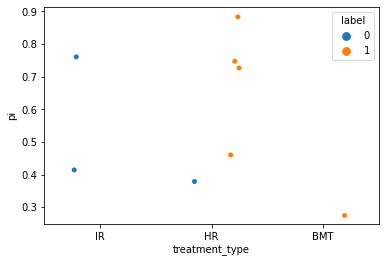

In [330]:
coef_df = pd.DataFrame(coefficients)
coef_mean = coef_df.mean().to_frame(name="pi")
results = coef_mean.join(metadata_pid[["label", "treatment_type"]])

ax = sns.stripplot(
  x="treatment_type", y="pi", hue="label",
  data=results, dodge=True
)

In [355]:
print(metadata_pid.loc[results.index, ["treatment_type", "label"]])
print(results)

     treatment_type  label
P058             IR      0
P122             HR      1
P131             HR      1
P137             HR      1
P146             HR      1
P160             HR      0
P167            BMT      1
P211             IR      0
            pi  label treatment_type
P058  0.760434      0             IR
P122  0.726598      1             HR
P131  0.747033      1             HR
P137  0.460076      1             HR
P146  0.883144      1             HR
P160  0.381454      0             HR
P167  0.277601      1            BMT
P211  0.414179      0             IR


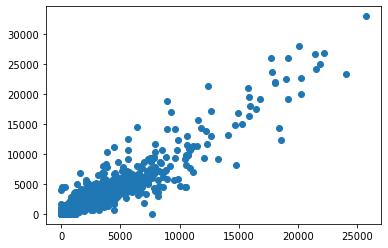

In [299]:
fig, ax = plt.subplots()
ax.scatter(D0, D8)

#### Objectives
- Come up with alternate method to estimate coefficients
- Show that it correctly estimates simulated data
- Use it to estimate real data
- See whether coefficient is an indicator of proportion of cells

- Are we able to use the LSE to estimate the synthetic data?
- How close are the synthetic data with the real data?
- Can we estimate coefficient by solving for the synthetic data that is most similar to the real data point?
- How can we make use of the 3 different normal samples?

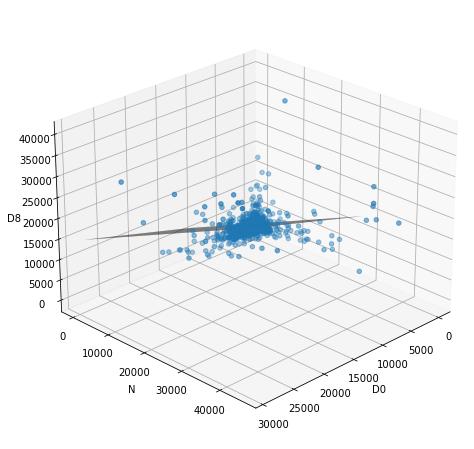

In [110]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(D0, N, D8)

xx, yy = np.meshgrid(range(0, 30000, 1000), range(0, 30000, 1000))
pi = model.coef_
z = pi * xx + (1 - pi) * yy 
ax.plot_surface(xx, yy, z, color="black", alpha=0.6)

ax.set_xlabel("D0")
ax.set_ylabel("N")
ax.set_zlabel("D8")
ax.view_init(25, 45)